
<b>INSTITUTO FEDERAL DE GOIÁS<br/>
PÓS-GRADUAÇÃO EM INTELIGÊNCIA ARTIFICIAL APLICADA<br/></b>
Disciplina: Processamento de Linguagem Natural  <br/>
Professor: Daniel Xavier de Sousa <br/>
Alunos: Wagner Silva, Cleibson, Marcos Rodrigues


---

In [2]:
# Bibliotecas básicas
import pandas as pd
import numpy as np

from tqdm import tqdm

# Bibliotecas para preparação dos dados
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

# Bibliotecas para exibição de gráficos
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, log_loss, f1_score, recall_score, precision_score, classification_report, average_precision_score, precision_recall_curve, roc_curve, auc
import seaborn as sbn

# Bibliotecas relacionadas à arquitetura da rede neural
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [327]:
MODEL = 'TFIDF+MLP'
DATASET = 'buscape'
K_FOLDS = 10
EPOCHS = 5

#+ 5%, 15%, 25%, 35%, and 50%
DROPOUT = 0.50
# 5e-4, 1e-3, 5e-3, 1e-2
LEARNING_RATE = 1e-2

TRAIN_NUM = '20'

In [4]:
# Importação do dataset buscape
df = pd.read_csv(f'../datasets/{DATASET}_preprocessed.csv')

In [5]:
df.shape

(133632, 2)

In [6]:
df.head(3)

,review_text,rating
0,estou muito satisfeito o visor e melhor do que...,1
1,muito boa o que gostei preco o que nao gostei ...,1
2,rapida otima qualidade de impressao e facil de...,1


#### Treinamento feito com 12.5% do dataset, 16704 instancias. Devido a problemas de sobrecarga de memória.

In [7]:
batch_1, batch_2 = train_test_split(df, test_size=0.5, stratify=df['rating'], random_state=42)
batch_3, batch_4 = train_test_split(batch_2, test_size=0.5, stratify=batch_2['rating'], random_state=42)
batch_5, batch_6 = train_test_split(batch_4, test_size=0.5, stratify=batch_4['rating'], random_state=42)
batch_7, batch_8 = train_test_split(batch_6, test_size=0.5, stratify=batch_6['rating'], random_state=42)
batch_9, batch_10 = train_test_split(batch_8, test_size=0.5, stratify=batch_8['rating'], random_state=42)
#batch_11, batch_12 = train_test_split(batch_10, test_size=0.5, stratify=batch_10['rating'], random_state=42)
print(batch_1.shape)
print(batch_2.shape)
print(batch_3.shape)
print(batch_4.shape)
print(batch_5.shape)
print(batch_6.shape)
print(batch_7.shape)
print(batch_8.shape)
print(batch_9.shape)
print(batch_10.shape)

(66816, 2)
(66816, 2)
(33408, 2)
(33408, 2)
(16704, 2)
(16704, 2)
(8352, 2)
(8352, 2)
(4176, 2)
(4176, 2)


In [8]:
batch_5.shape[0]

16704

In [9]:
# Verificando quantidade de ratings
batch_5['rating'].value_counts()

rating
0    8352
1    8352
Name: count, dtype: int64

In [10]:
# Definindo documents e labels
documents = batch_5['review_text'].tolist()
labels = np.array(batch_5['rating'])

In [11]:
# Gerando tfidf matrix
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=8, max_df=0.3)
TFIDF_MATRIX = tfidf_vectorizer.fit_transform(np.array(documents))

In [328]:
BATCH_SIZE = 32
LOSS = 'binary_crossentropy'
METRICS = ['acc']
CALLBACKS=[EarlyStopping('loss', patience=3)]
VERBOSE = 0

In [329]:
# Definindo quantidade de folds para cross validation
KFOLD = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)

In [330]:
train_fold_losses = []
train_fold_accuracies = []
train_fold_f1_scores = []

val_fold_accuracies = []
val_fold_f1_scores = []

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

val_tprs = []
val_aucs = []
val_mean_fpr = np.linspace(0, 1, 100)

for fold, (train_idx, test_idx) in tqdm(enumerate(KFOLD.split(TFIDF_MATRIX), start=1), desc="Processing"):
    print(f'fold ---> {fold}')
    
    # Separando datasets
    X_train, X_test = TFIDF_MATRIX[train_idx], TFIDF_MATRIX[test_idx]
    y_train, y_test = labels[train_idx], labels[test_idx]
    
    # Arquitetura MLP
    model = Sequential()
    model.add(Dense(24, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(DROPOUT)),
    model.add(Dense(1, activation='sigmoid'))
    
    # Compilando o modelo
    LEARNING_RATE = LEARNING_RATE
    OPTIMIZER = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)
    
    # Treinando o modelo
    model_history = model.fit(
        X_train.toarray(),
        y_train, 
        epochs=EPOCHS, 
        batch_size=BATCH_SIZE, 
        verbose=VERBOSE, 
        callbacks=CALLBACKS,
        validation_data=(X_test.toarray(), y_test)
    )
    
    # ------------------------------------------------------------------
    # Metricas Treino
    
    # Predicoes treino
    train_pred = (model.predict(X_train.toarray()) > 0.5).astype(int)
    
    # Treino loss em cada fold
    train_fold_losses.append(model_history.history['loss'])
    
    # Treino acuracia em cada fold
    train_fold_accuracies.append(model_history.history['acc'])
    
    # Treino f1 score em cada fold
    train_fold_f1 = f1_score(y_train, train_pred)
    train_fold_f1_scores.append(train_fold_f1)
    
    # treino roc curve and auc
    fpr, tpr, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(fpr, tpr)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    aucs.append(roc_auc)
    
    # ------------------------------------------------------------------
    # Metricas Validacao
    
    # Avaliando o modelo
    val_pred = (model.predict(X_test.toarray()) > 0.5).astype(int)
    
    # Validacao acuracia em cada fold
    val_fold_accuracy = accuracy_score(y_test, val_pred)
    val_fold_accuracies.append(val_fold_accuracy)
    
    # Validacao f1 score em cada fold
    val_fold_f1 = f1_score(y_test, val_pred)
    val_fold_f1_scores.append(val_fold_f1)

print('finished train!')

Processing: 0it [00:00, ?it/s]

fold ---> 1
53/53 [==============================] - 0s 2ms/step


Processing: 1it [00:20, 20.96s/it]

fold ---> 2
53/53 [==============================] - 0s 3ms/step


Processing: 2it [00:43, 22.03s/it]

fold ---> 3
53/53 [==============================] - 0s 2ms/step


Processing: 3it [01:04, 21.45s/it]

fold ---> 4
53/53 [==============================] - 0s 2ms/step


Processing: 4it [01:26, 21.75s/it]

fold ---> 5
53/53 [==============================] - 0s 2ms/step


Processing: 5it [01:49, 22.25s/it]

fold ---> 6
53/53 [==============================] - 0s 3ms/step


Processing: 6it [02:16, 23.69s/it]

fold ---> 7
53/53 [==============================] - 0s 2ms/step


Processing: 7it [02:37, 22.74s/it]

fold ---> 8
53/53 [==============================] - 0s 2ms/step


Processing: 8it [02:59, 22.72s/it]

fold ---> 9
53/53 [==============================] - 0s 2ms/step


Processing: 9it [03:19, 21.84s/it]

fold ---> 10
53/53 [==============================] - 0s 2ms/step


Processing: 10it [03:41, 22.15s/it]

finished train!


In [331]:
print(f'train accuracies mean: {round(np.mean(train_fold_accuracies),4)}')
print(f'train f1 scores mean: {round(np.mean(train_fold_f1_scores),4)}')
print('-'*80)
print(f'val accuracies mean: {round(np.mean(val_fold_accuracies),4)}')
print(f'val f1 scores mean: {round(np.mean(val_fold_f1_scores),4)}')

train accuracies mean: 0.9272
train f1 scores mean: 0.9838
--------------------------------------------------------------------------------
val accuracies mean: 0.9031
val f1 scores mean: 0.9032


In [332]:
graph_path = f'01_tfidf_mlp_train_{TRAIN_NUM}'

In [333]:
def plot_eval_metrics(model, metric):
    plt.plot(model.history[metric])
    plt.plot(model.history[f'val_{metric}'])
    plt.title(f'model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(f'./graphs/{graph_path}/train_test_{metric}.png')
    plt.show()

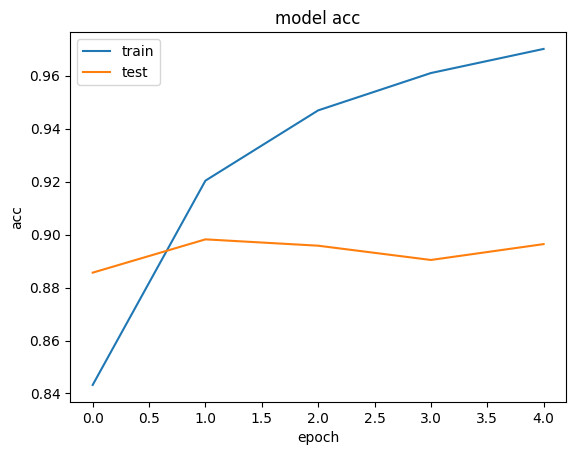

In [334]:
plot_eval_metrics(model_history, 'acc')

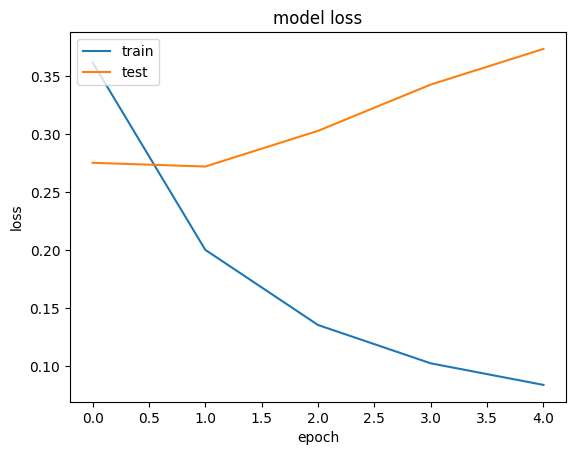

In [335]:
plot_eval_metrics(model_history, 'loss')

In [336]:
def plot_train_folds(history, metric):
    plt.figure(figsize=(10, 6))
    for fold_num, fold_loss in enumerate(history):
        plt.plot(fold_loss, label=f'Fold {fold_num+1}')
    plt.xlabel('Epoch')
    plt.ylabel(f'Training {metric}')
    plt.title(f'Training {metric} per Epoch for Each Fold')
    plt.legend()
    plt.savefig(f'./graphs/{graph_path}/train_folds_{metric}.png')
    plt.show()

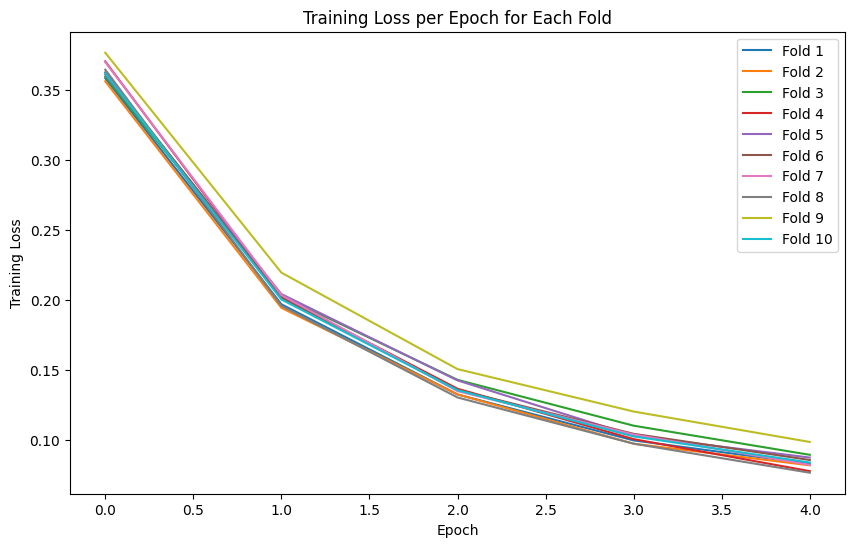

In [337]:
plot_train_folds(train_fold_losses, 'Loss')

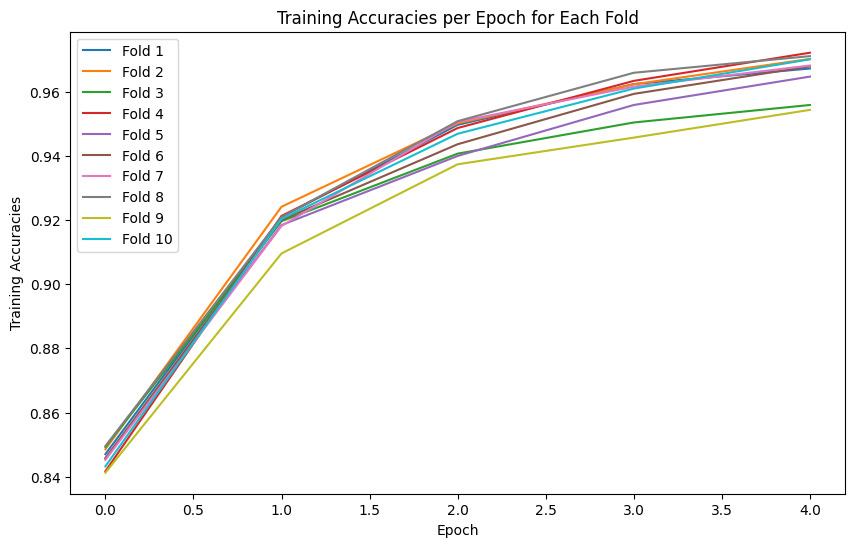

In [338]:
plot_train_folds(train_fold_accuracies, 'Accuracies')

In [339]:
def plot_roc_auc_curve(desc, mean_tpr, mean_auc):
    plt.figure()
    plt.plot(mean_fpr, mean_tpr, color='b', label=f'{desc} Mean ROC curve (AUC = {mean_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{desc} Mean Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.savefig(f'./graphs/{graph_path}/train_roc_auc_curve_{desc}.png')
    plt.show()

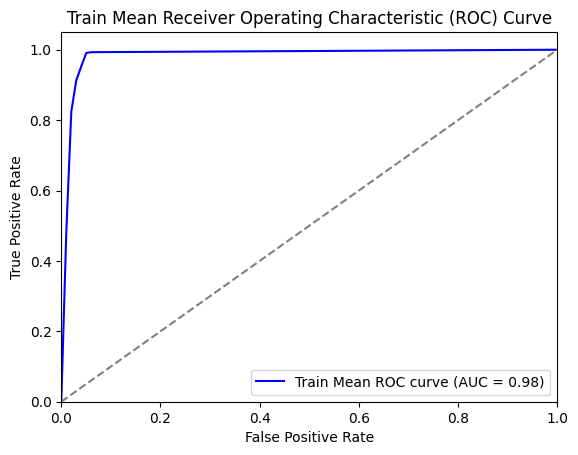

In [340]:
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plot_roc_auc_curve('Train', mean_tpr, mean_auc)

In [341]:
predict = np.round(model.predict(X_test.toarray()))

53/53 [==============================] - 0s 2ms/step


In [342]:
accuracy = accuracy_score(y_test, predict)
accuracy

0.8964071856287426

In [343]:
def plot_confunsion_matrix(cm):
    plt.figure(figsize=(6,4))
    sbn.heatmap(cm, annot=True, linewidth=0.2, annot_kws={'size':12}, fmt='.0f')
    plt.title("Matriz de Confusão", fontsize=12)
    plt.xlabel('Real')
    plt.ylabel('Predito')
    plt.savefig(f'./graphs/{graph_path}/test_conf_matrix.png')
    plt.show()

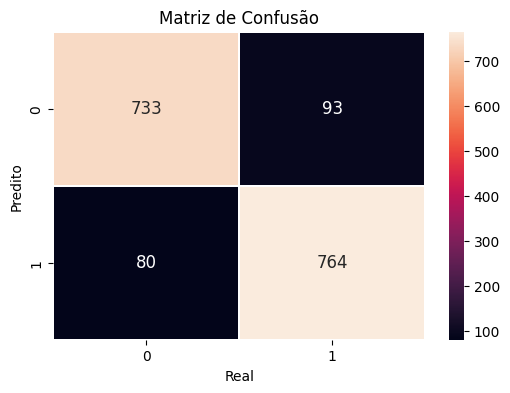

In [344]:
cm = confusion_matrix(y_test, predict)
plot_confunsion_matrix(cm)